# MMC - Laboratorium 7 - Bartosz Sosik (310287)

## Zadanie 3

Celem zadania jest wyznaczenie niepewności pomiaru płytki. W tym celu zaimplementowano model Monte Carlo propagacji niepewności pomiaru: \
$Y = X_1 + X_2 + X_3 + X_4 -X_1[X_8(X_6+X_7)+X_5X_9] - K$. \
$K$ to nominalna długość płytki wynosząca 50mm. Zmienne X to zmienne losowe o różnych rozkładach:
- Shifted t-Student $t_v(\mu, \sigma^2)$ 
- Równomierny $R(a,b)$
- Gaussa $N(\mu, \sigma^2)$
- Arcus sinus $U(a,b)$
- Trapezowy $C_t(a,b,d)$

Generatory zmiennych z tych rozkładów zostały zaimplementowane jako funkcje Pythona:

In [1]:
from matplotlib import pyplot as plt
import math
import random
import numpy as np
from scipy.stats import norm, t

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Generatory zmiennych z założonych rozkładów

In [243]:
# Rozkład Shifted t-Student
def generate_tv(mi, sigma, v):
    tv = t.rvs(v, mi, sigma, size=1)[0]
    # return mi + (tv*sigma)/(math.sqrt(v+1))
    return tv

In [203]:
# Rozkład równomierny
def generate_uniform(a, b):
    return random.uniform(a, b)

In [204]:
# Rozkład arcus sinus
def generate_arcsin(a, b):
    r = random.uniform(0, 1)
    sample = (a+b)/2 + ((b-a)/2)*math.sin(2*math.pi*r)
    return sample

In [226]:
# Rozkład Gaussa
def generate_gauss(mi, sigma):
    return random.normalvariate(mi, sigma)

In [206]:
# Rozkład trapezowy
def generate_trap(a,b,d):
    r1 = random.uniform(0, 1)
    r2 = random.uniform(0, 1)
    sample = a + ((b-a)/2)*((1+d)*r1 + (1-d)*r2)
    return sample

### Model Monte Carlo

In [244]:
# Pojedynczy eksperyment MC liczący nepewność pomiaru
def calculate_error():
    X1 = generate_tv(50000623, 25, 18)
    X2 = generate_tv(215, 6, 24)
    X3 = generate_tv(0, 4, 5)
    X4 = generate_tv(0, 7, 8)
    X5 = generate_uniform(9.5*pow(10, -6), 1.35*pow(10, -5))
    X6 = generate_gauss(-0.1, 0.2)
    X7 = generate_arcsin(-0.5, 0.5)
    X8 = generate_trap(-1*pow(10,-6), 1*pow(10, -6), 1*pow(10,-7))
    X9 = generate_trap(-0.05, 0.05, 0.025)
    Y = X1 + X2 + X3 + X4 - X1*(X8*(X6+X7)+X5*X9) - 50*pow(10, 6)
    return Y

Przeprowadzonych zostało 100 tys. eksperymentów Monte Carlo. W każdej iteracji liczona była niepewnośc pomiaru i zapisywana do listy. \
Estymator tej niepewności liczony jest jako średnia wyników: $y_e=\frac{1}{M}\sum_{i=1}^{M}y_r$ \
Odchylenie standardowe estymatora liczymy jako: $\sigma = \sqrt(\frac{1}{M-1}\sum_{r=1}{M}(y_r-y_e)^2)$

In [260]:
# M eksperymentów Monte Carlo
M = 1000000
errors = []
for i in range(M):
    Y = calculate_error()
    errors.append(Y)

# Estymator Y
estimator = np.mean(errors)

# Std. deviation of estimator Y
sum_ = 0
for error in errors:
    sum_ += (error-estimator)**2
std = math.sqrt(1/(M-1)*sum_)

In [262]:
print(f'Estymator Y: {estimator}')
print(f'Odchylenie standardowe: {std}')

Estymator Y: 837.9870713967944
Odchylenie standardowe: 32.308941061024036


Następnie wyznaczony został przedział rozproszenia dla $p=0.99$. Ilość obserwacji, które nie mieszczą się w tym przedziale to $M-q$, gdzie $q=pM$. Wartości graniczne to: \
$y_{min} = y_r[(M-q)/2]$ oraz \
$y_{max} = y_r[(M-q)/2+q]$.

In [274]:
p = 0.99
q = int(M*p)
sorted_errors = sorted(errors)
r_star = int((M-q)/2)
y_min = sorted_errors[r_star+1]
y_max = sorted_errors[r_star+q+1]
dispersion = [y_min, y_max]
print(f'Przedział rozproszenia: {dispersion}')

Przedział rozproszenia: [752.3814921602607, 923.55761885643]


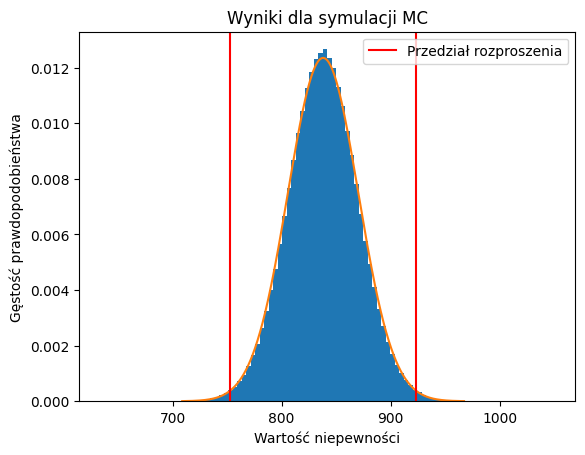

In [270]:
x = np.linspace(estimator - 4*std, estimator + 4*std, 1000)
y = norm.pdf(x, estimator, std)
plt.hist(errors, bins=100, density=True)
plt.plot(x,y)
plt.axvline(dispersion[0], color='r', label='Przedział rozproszenia')
plt.axvline(dispersion[1], color='r')
plt.title('Wyniki dla symulacji MC')
plt.xlabel('Wartość niepewności')
plt.ylabel('Gęstość prawdopodobieństwa')
plt.legend(loc='best')

Wyniki eksperymentu przypominaja te osiągnięte przez autorów artykułu. Porównanie przedstawione zostało w poniższej tabeli:
| Wielkość | Wynik | Artykuł |
|:---------|:--------:|---------:|
|  Estymata  |  837.98   |  838   |
|  Odchylenie standardowe   |  32.31   |  36  |
|  Przedział rozproszenia   |  [752.38, 923.56]  |  [745, 932]   |

Estymaty są praktycznie takie same. \
W moim przypadku uzyskano mniejsze odchylenie standardowe o około 3.7 w porównaniu do autorów artykułu. Uzyskali oni natomiast odchylenie standardowe 32 za pomocą metody GUF. \
W związku z tym że uzyskałem mniejsze odchylenie standardowe, również uzyskany przedział rozproszenia jest mniejszy i bardziej "zbity". \
Różnice te mogą wynikać ze sposobu liczenia powyższych wartości a także niedeterministycznej natury eksperymentów Monte Carlo.